In [2]:
%pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached gymnasium-1.1.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached sb3_contrib-2.6.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached stable_baselines3-2.6.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached typing-3.7.4.3-py3-none-any.whl
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
  Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached pyaml-25.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.m

In [51]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    "curriculum": True
}

In [3]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
        'random_start':True,
        "curriculum": True
    }
    env = greenCrabMonthEnv(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [4]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-04-17 07:16:09,572	INFO worker.py:1841 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.0178
Function value obtained: 27.5713
Current minimum: 27.5713
Iteration No: 2 started. Evaluating function at random point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3700
Function value obtained: 20.3969
Current minimum: 20.3969
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3714
Function value obtained: 24.0387
Current minimum: 20.3969
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3700
Function value obtained: 23.1161
Current minimum: 20.3969
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3810
Function value obtained: 36.2180
Current minimum: 20.3969
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 0.3682
Function value obtained: 50.7848
Current minimum: 20.3969
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Ev

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 0.5349
Function value obtained: 19.2720
Current minimum: 6.5987
Iteration No: 12 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 0.5499
Function value obtained: 6.3255
Current minimum: 6.3255
Iteration No: 13 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5856
Function value obtained: 6.0073
Current minimum: 6.0073
Iteration No: 14 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.5804
Function value obtained: 5.6652
Current minimum: 5.6652
Iteration No: 15 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.6012
Function value obtained: 4.9097
Current minimum: 4.9097
Iteration No: 16 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.5917
Function value obtained: 3.7888
Current minimum: 3.7888
Iteration No: 17 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6014
Function value obtained: 3.1433
Current minimum: 3.1433
Iteration No: 18 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.5450
Function value obtained: 3.0411
Current minimum: 3.0411
Iteration No: 19 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.6487
Function value obtained: 4.1925
Current minimum: 3.0411
Iteration No: 20 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.6234
Function value obtained: 8.0646
Current minimum: 3.0411
Iteration No: 21 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.6379
Function value obtained: 6.2155
Current minimum: 3.0411
Iteration No: 22 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.6071
Function value obtained: 3.4799
Current minimum: 3.0411
Iteration No: 23 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6433
Function value obtained: 16.0299
Current minimum: 3.0411
Iteration No: 24 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.6145
Function value obtained: 2.9667
Current minimum: 2.9667
Iteration No: 25 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6958
Function value obtained: 2.9270
Current minimum: 2.9270
Iteration No: 26 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.7907
Function value obtained: 2.7517
Current minimum: 2.7517
Iteration No: 27 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.7143
Function value obtained: 3.7135
Current minimum: 2.7517
Iteration No: 28 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.6758
Function value obtained: 2.9934
Current minimum: 2.7517
Iteration No: 29 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6335
Function value obtained: 2.9987
Current minimum: 2.7517
Iteration No: 30 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.6901
Function value obtained: 2.9551
Current minimum: 2.7517
Iteration No: 31 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.6362
Function value obtained: 3.0388
Current minimum: 2.7517
Iteration No: 32 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.6709
Function value obtained: 2.9741
Current minimum: 2.7517
Iteration No: 33 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.6286
Function value obtained: 6.0633
Current minimum: 2.7517
Iteration No: 34 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.7100
Function value obtained: 2.7498
Current minimum: 2.7498
Iteration No: 35 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.6967
Function value obtained: 2.7692
Current minimum: 2.7498
Iteration No: 36 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.7584
Function value obtained: 5.0327
Current minimum: 2.7498
Iteration No: 37 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.7238
Function value obtained: 2.8507
Current minimum: 2.7498
Iteration No: 38 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.7112
Function value obtained: 2.9461
Current minimum: 2.7498
Iteration No: 39 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.6618
Function value obtained: 3.0919
Current minimum: 2.7498
Iteration No: 40 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.6451
Function value obtained: 2.9408
Current minimum: 2.7498
Iteration No: 41 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.7449
Function value obtained: 8.3102
Current minimum: 2.7498
Iteration No: 42 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.7213
Function value obtained: 7.7269
Current minimum: 2.7498
Iteration No: 43 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.7221
Function value obtained: 3.1329
Current minimum: 2.7498
Iteration No: 44 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.7823
Function value obtained: 10.1120
Current minimum: 2.7498
Iteration No: 45 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.6762
Function value obtained: 3.0867
Current minimum: 2.7498
Iteration No: 46 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.8405
Function value obtained: 16.1511
Current minimum: 2.7498
Iteration No: 47 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.9507
Function value obtained: 2.9805
Current minimum: 2.7498
Iteration No: 48 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.8565
Function value obtained: 3.1881
Current minimum: 2.7498
Iteration No: 49 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 0.8996
Function value obtained: 5.0376
Current minimum: 2.7498
Iteration No: 50 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 0.9326
Function value obtained: 11.0543
Current minimum: 2.7498
Iteration No: 51 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.8994
Function value obtained: 2.9870
Current minimum: 2.7498
Iteration No: 52 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.9967
Function value obtained: 2.8345
Current minimum: 2.7498
Iteration No: 53 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.9074
Function value obtained: 2.9125
Current minimum: 2.7498
Iteration No: 54 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.9016
Function value obtained: 15.3740
Current minimum: 2.7498
Iteration No: 55 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 1.1329
Function value obtained: 2.8517
Current minimum: 2.7498
Iteration No: 56 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.8902
Function value obtained: 3.0803
Current minimum: 2.7498
Iteration No: 57 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.0264
Function value obtained: 7.1787
Current minimum: 2.7498
Iteration No: 58 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.9405
Function value obtained: 2.9865
Current minimum: 2.7498
Iteration No: 59 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 0.9787
Function value obtained: 40.0615
Current minimum: 2.7498
Iteration No: 60 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 0.9360
Function value obtained: 2.7973
Current minimum: 2.7498
Iteration No: 61 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 0.9855
Function value obtained: 2.9385
Current minimum: 2.7498
Iteration No: 62 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.0006
Function value obtained: 2.8997
Current minimum: 2.7498
Iteration No: 63 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.0025
Function value obtained: 3.4145
Current minimum: 2.7498
Iteration No: 64 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.0401
Function value obtained: 2.8138
Current minimum: 2.7498
Iteration No: 65 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.0131
Function value obtained: 2.8359
Current minimum: 2.7498
Iteration No: 66 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.0739
Function value obtained: 2.9654
Current minimum: 2.7498
Iteration No: 67 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.0302
Function value obtained: 2.9738
Current minimum: 2.7498
Iteration No: 68 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 0.9845
Function value obtained: 2.8885
Current minimum: 2.7498
Iteration No: 69 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.0234
Function value obtained: 5.8348
Current minimum: 2.7498
Iteration No: 70 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.2231
Function value obtained: 11.1129
Current minimum: 2.7498
Iteration No: 71 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 1.1651
Function value obtained: 4.3909
Current minimum: 2.7498
Iteration No: 72 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 1.1678
Function value obtained: 6.3825
Current minimum: 2.7498
Iteration No: 73 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.0965
Function value obtained: 9.0135
Current minimum: 2.7498
Iteration No: 74 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.0945
Function value obtained: 5.4478
Current minimum: 2.7498
Iteration No: 75 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.1400
Function value obtained: 11.7209
Current minimum: 2.7498
Iteration No: 76 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.1438
Function value obtained: 2.8376
Current minimum: 2.7498
Iteration No: 77 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.1542
Function value obtained: 2.9502
Current minimum: 2.7498
Iteration No: 78 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.0579
Function value obtained: 2.8457
Current minimum: 2.7498
Iteration No: 79 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.2879
Function value obtained: 11.8554
Current minimum: 2.7498
Iteration No: 80 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.1371
Function value obtained: 3.0034
Current minimum: 2.7498
Iteration No: 81 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.1131
Function value obtained: 3.2366
Current minimum: 2.7498
Iteration No: 82 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.0921
Function value obtained: 2.8802
Current minimum: 2.7498
Iteration No: 83 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.0996
Function value obtained: 42.6828
Current minimum: 2.7498
Iteration No: 84 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.2038
Function value obtained: 3.7082
Current minimum: 2.7498
Iteration No: 85 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.2267
Function value obtained: 2.8537
Current minimum: 2.7498
Iteration No: 86 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.1049
Function value obtained: 2.9608
Current minimum: 2.7498
Iteration No: 87 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 1.1654
Function value obtained: 2.9291
Current minimum: 2.7498
Iteration No: 88 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.2511
Function value obtained: 3.4485
Current minimum: 2.7498
Iteration No: 89 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.3933
Function value obtained: 2.8557
Current minimum: 2.7498
Iteration No: 90 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.3130
Function value obtained: 2.9972
Current minimum: 2.7498
Iteration No: 91 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.3223
Function value obtained: 48.0342
Current minimum: 2.7498
Iteration No: 92 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.2697
Function value obtained: 8.6212
Current minimum: 2.7498
Iteration No: 93 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.4154
Function value obtained: 3.8069
Current minimum: 2.7498
Iteration No: 94 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.4250
Function value obtained: 8.2029
Current minimum: 2.7498
Iteration No: 95 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.3767
Function value obtained: 2.8244
Current minimum: 2.7498
Iteration No: 96 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.4021
Function value obtained: 4.4847
Current minimum: 2.7498
Iteration No: 97 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.4925
Function value obtained: 3.0709
Current minimum: 2.7498
Iteration No: 98 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.4037
Function value obtained: 3.0712
Current minimum: 2.7498
Iteration No: 99 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.5323
Function value obtained: 3.0169
Current minimum: 2.7498
Iteration No: 100 started. Searching for the next optimal point.


/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.4065
Function value obtained: 6.2599
Current minimum: 2.7498
CPU times: user 53min 6s, sys: 9.27 s, total: 53min 15s
Wall time: 1min 32s


[83.87232800633504, 596.3225575635984, 14.882297944474463]

In [4]:
# with nonNormalized env
evaluateConstAct(
    [83.87232800633504, 596.3225575635984, 14.882297944474463]
)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
2025-05-02 17:34:41,988	INFO worker.py:1888 -- Started a local Ray instance.


2.717293347596187

In [5]:
import ray
ray.shutdown()

In [6]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([0.0, 265.6788011729134, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,0.0,0.0,0.0,265.678801,0.0,0.000000,0
1,1,0.0,0.0,0.0,265.678801,0.0,-0.007146,0
2,2,0.0,0.0,0.0,265.678801,0.0,-0.014292,0
3,3,0.0,0.0,0.0,265.678801,0.0,-0.021438,0
4,4,0.0,0.0,0.0,265.678801,0.0,-0.028584,0


<Axes: xlabel='t'>

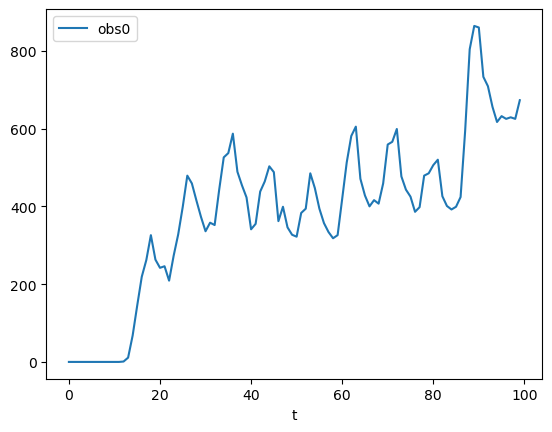

In [7]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [8]:
def environment_simulation(env, agent, reps=10, obs_names = None, acts_names = None):
    num_obs = np.prod(len(env.observation_space))
    num_acts = np.prod(env.action_space.shape)
    obs_names = obs_names or [f'obs{i}' for i in range(num_obs)]
    acts_names = acts_names or [f'act{i}' for i in range(num_acts)]
    #
    data = {
        't': [],
        **{obsn: [] for obsn in obs_names},
        **{actn: [] for actn in acts_names},
        'rew': [],
        'rep': [],
        'crab_pop':[]
    }
    env = env
    agent = agent
    for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            #
            data['rew'].append(episode_reward)
            data['rep'].append(rep)
            data['t'].append(t)
            data['crab_pop'].append(env.state)
            for idx, obs_name in enumerate(obs_names):
                data[obs_name].append(observation['crabs'][idx])
            for idx, act_name in enumerate(acts_names):
                data[act_name].append(action[idx])
            #
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            #
            if terminated or done:
                break
    return data

In [9]:
agent = multiConstAction(env=env, action=np.array([0.0, 0, 0.0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0,"[0.0011555300034430604, 0.01915615796838033, 0..."
1,1,0.0,0.0,0.0,0.0,0.0,-0.166599,0,"[63.053324812978346, 951.5032455207618, 3751.8..."
2,2,0.0,0.0,0.0,0.0,0.0,-0.378973,0,"[6.343957724333546, 151.284587185763, 1155.665..."
3,3,0.0,0.0,0.0,0.0,0.0,-0.621173,0,"[0.6830845756405602, 22.33359309772908, 263.42..."
4,4,0.0,0.0,0.0,0.0,0.0,-0.878253,0,"[0.01584703070847266, 2.8414324584547925, 52.7..."


In [10]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df.head()

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.001156,0.019156,0.218833,1.723850,9.370495,35.169636,91.189028,163.403578,202.412300,173.344773,...,11.870543,2.317191,0.312158,0.029001,0.001857,0.000082,0.000002,5.185573e-08,7.439094e-10,0
1,63.053325,951.503246,3751.870019,3499.877284,1092.583869,125.032411,102.374244,370.376450,832.387714,1147.613054,...,438.905611,426.502433,422.288942,366.869177,288.697296,212.260857,144.462871,9.309161e+01,4.306530e+01,1
2,6.343958,151.284587,1155.665550,3237.541550,3161.150537,1255.871320,245.649010,191.148965,519.283808,941.573989,...,565.073011,452.166439,434.784502,391.813365,316.393245,235.921282,161.822492,9.981666e+01,4.711396e+01,2
3,0.683085,22.333593,263.426683,1327.934540,2942.602854,2812.723254,1255.488436,343.955297,319.687370,674.232980,...,734.064300,520.699835,452.865124,413.079404,341.214420,256.238985,177.787677,1.098412e+02,5.096015e+01,3
4,0.015847,2.841432,52.741506,399.461189,1488.234538,2746.104631,2490.971858,1173.491002,425.762528,473.311898,...,889.744185,644.015432,496.832144,438.483641,370.395506,282.139915,194.690353,1.196649e+02,5.480328e+01,4


In [11]:
def plot_selected_sizes(expanded_df:pd.DataFrame, selected_sizes):
    plt.figure(figsize=(12, 8))
    time = expanded_df['t']  # Time column

    # If no sizes selected, show a placeholder message
    if not selected_sizes:
        plt.text(0.5, 0.5, 'No sizes selected', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.show()
        return

    # Plot each selected size
    for col in selected_sizes:
        plt.plot(time, expanded_df[col], label=col)

    # Customize the plot
    plt.title("Green Crab Population Change Over Time", fontsize=16)
    plt.xlabel("Time (t)", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.legend(title="Crab Sizes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

### normalized environment

In [12]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    "curriculum": True
}

In [13]:
env = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [14]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    rewards = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200, return_episode_rewards=True)
    m_reward = np.mean(rewards)
    return -m_reward, rewards

In [15]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [16]:
norm_act = normalized_action([83.87232800633504, 596.3225575635984, 14.882297944474463], 3000)
m_reward, const_rews = evaluateConstAct(norm_act)
np.mean(const_rews)

2025-05-02 17:35:16,623	INFO worker.py:1888 -- Started a local Ray instance.


-2.7191661833645355

In [17]:
import ray
ray.shutdown()

In [18]:
agent = multiConstAction(env=env, action=np.array(norm_act))

In [19]:
constantData = simulator(env = env, agent = agent).simulate_full_named_dict_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.944085,-0.602452,-0.990078,0.000000,0
1,1,-1.0,-1.0,-0.944085,-0.602452,-0.990078,-0.020184,0
2,2,-1.0,-1.0,-0.944085,-0.602452,-0.990078,-0.040368,0
3,3,-1.0,-1.0,-0.944085,-0.602452,-0.990078,-0.060552,0
4,4,-1.0,-1.0,-0.944085,-0.602452,-0.990078,-0.080736,0


<Axes: xlabel='t'>

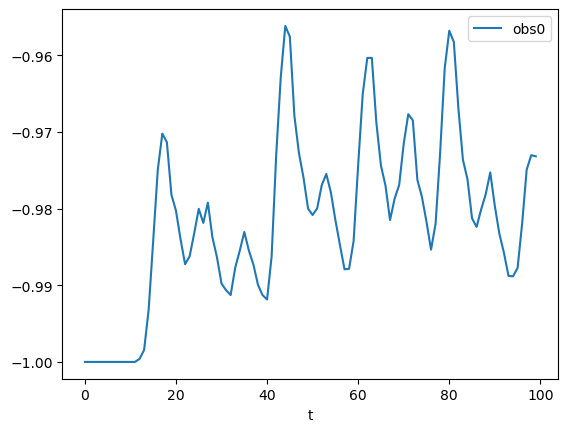

In [20]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [52]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [53]:
evalEnv = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [54]:
td3Agent = TD3.load("TD3_gcmenorm_curriculumn", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm_curriculumn", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [55]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-06-04 04:12:53,140	INFO worker.py:1888 -- Started a local Ray instance.


In [56]:
N_EPS = 200

ppo_rews = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
td3_rews = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
tqc_rews = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)
reppo_rews = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS, return_episode_rewards=True)

In [57]:
import ray
ray.shutdown()

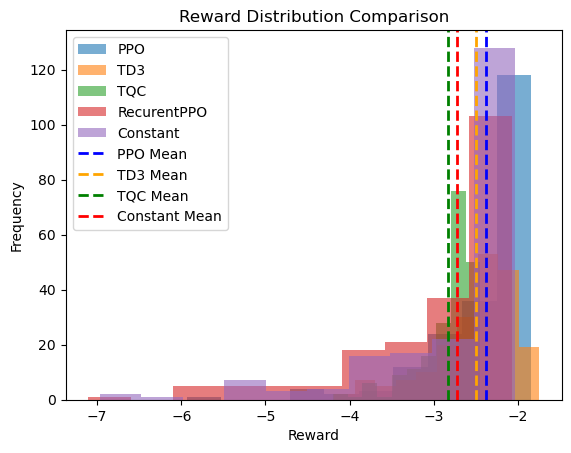

In [58]:
plt.hist(ppo_rews, alpha=0.6, label='PPO')
plt.hist(td3_rews, alpha=0.6, label='TD3')
plt.hist(tqc_rews, alpha=0.6, label='TQC')
plt.hist(reppo_rews , alpha=0.6, label='RecurentPPO')
plt.hist(const_rews, alpha=0.6, label='Constant')

# Mark means with vertical lines
plt.axvline(np.mean(ppo_rews), color='blue', linestyle='dashed', linewidth=2, label='PPO Mean')
plt.axvline(np.mean(td3_rews), color='orange', linestyle='dashed', linewidth=2, label='TD3 Mean')
plt.axvline(np.mean(tqc_rews), color='green', linestyle='dashed', linewidth=2, label='TQC Mean')
plt.axvline(np.mean(const_rews), color='red', linestyle='dashed', linewidth=2, label='Constant Mean')

plt.legend()
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution Comparison")
plt.show()

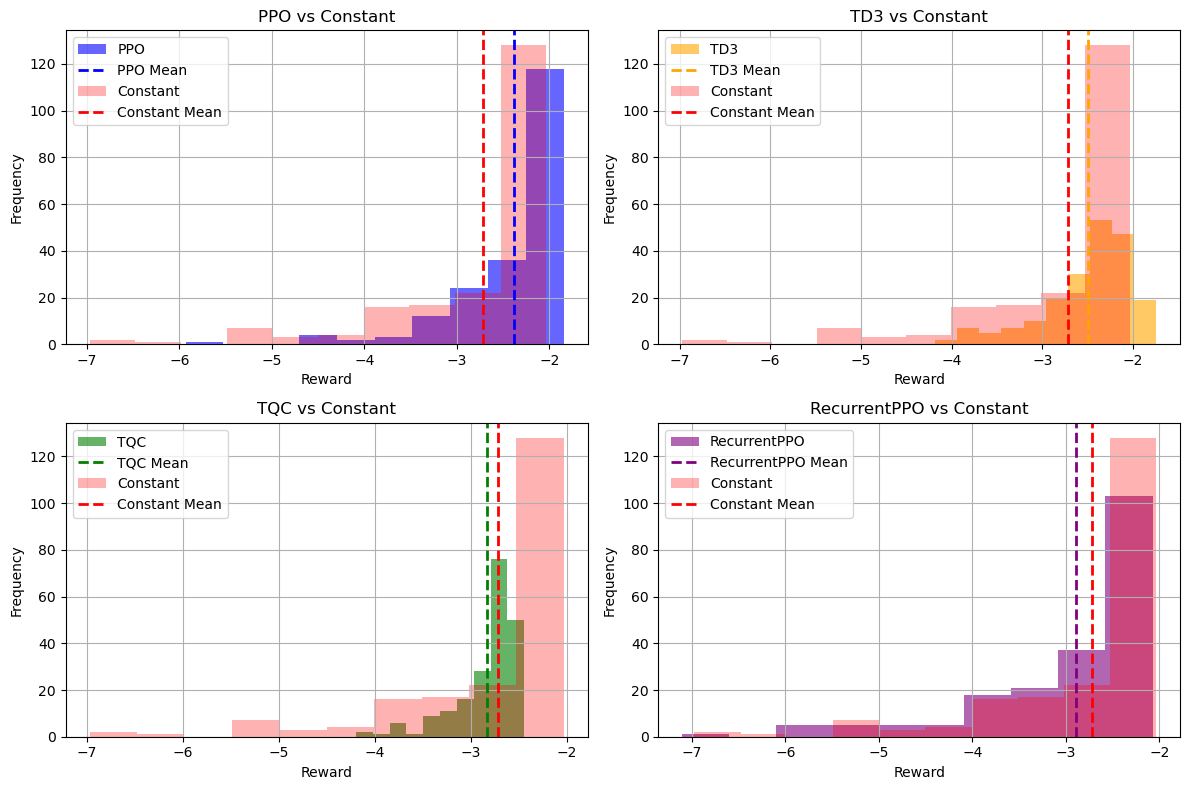

In [59]:
models = {
    'PPO': ppo_rews,
    'TD3': td3_rews,
    'TQC': tqc_rews,
    'RecurrentPPO': reppo_rews,
}
constant_rewards = const_rews

colors = {
    'PPO': 'blue',
    'TD3': 'orange',
    'TQC': 'green',
    'RecurrentPPO': 'purple',
    'Constant': 'red'
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, (model_name, rewards) in enumerate(models.items()):
    ax = axes[i]
    # Plot current model
    ax.hist(rewards, alpha=0.6, color=colors[model_name], label=model_name)
    ax.axvline(np.mean(rewards), color=colors[model_name], linestyle='dashed', linewidth=2, label=f'{model_name} Mean')

    # Plot constant model
    ax.hist(constant_rewards, alpha=0.3, color=colors['Constant'], label='Constant')
    ax.axvline(np.mean(constant_rewards), color=colors['Constant'], linestyle='dashed', linewidth=2, label='Constant Mean')

    ax.set_title(f"{model_name} vs Constant")
    ax.set_xlabel("Reward")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [42]:
np.std(ppo_rews), np.std(td3_rews), np.std(tqc_rews), np.std(reppo_rews)

(0.5099703001046377,
 0.47506378859874937,
 0.3010087714729416,
 1.1809867481140361)

In [49]:
np.mean(ppo_rews), np.mean(td3_rews), np.mean(tqc_rews), np.mean(reppo_rews)

(-2.438835619854061,
 -2.6101172776095587,
 -2.920829037340845,
 -3.5949607501327834)

In [30]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -2.3242858601980334
TQC mean rew = -2.8090474486978096
TD3 mean rew = -2.5670113824847935
RecurrentPPO mean rew = -3.046527999271333



### PPO plot

In [60]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-0.889998,-1.0,0.000000,0
1,1,-1.0,-1.0,-1.0,-0.220946,-1.0,-0.004461,0
2,2,-1.0,-1.0,-1.0,-0.396981,-1.0,-0.035685,0
3,3,-1.0,-1.0,-1.0,-0.437380,-1.0,-0.059867,0
4,4,-1.0,-1.0,-1.0,-0.789578,-1.0,-0.082433,0


<Axes: xlabel='t'>

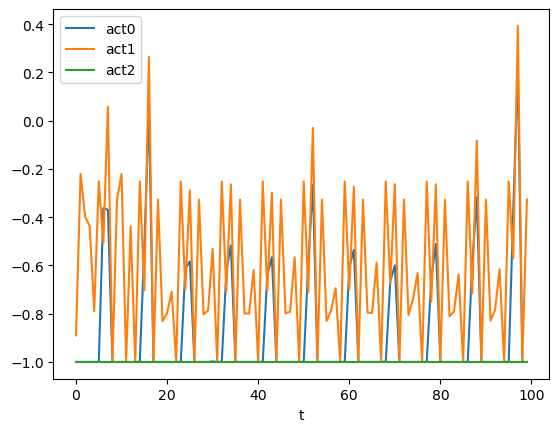

In [61]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

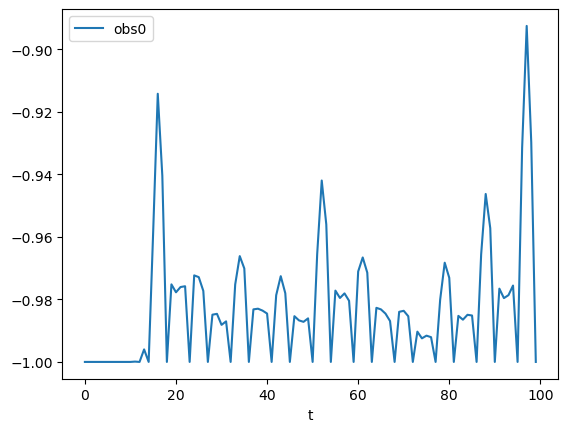

In [62]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])

In [34]:
ppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.00000,-1.0,-1.000000,-1.000000,0.000000,0
1,1,-1.000000,-1.00000,-1.0,-1.000000,-1.000000,-0.000571,0
2,2,-1.000000,-1.00000,-1.0,-1.000000,-1.000000,-0.001535,0
3,3,-1.000000,-1.00000,-1.0,-0.901089,-1.000000,-0.003421,0
4,4,-0.984498,11.33324,-1.0,-0.612973,-0.883745,-0.010954,0


<Axes: xlabel='t'>

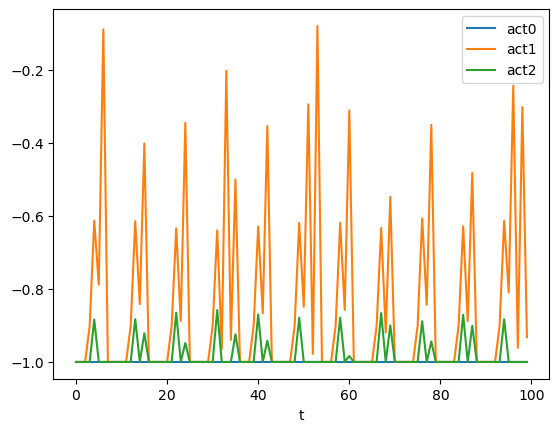

In [35]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

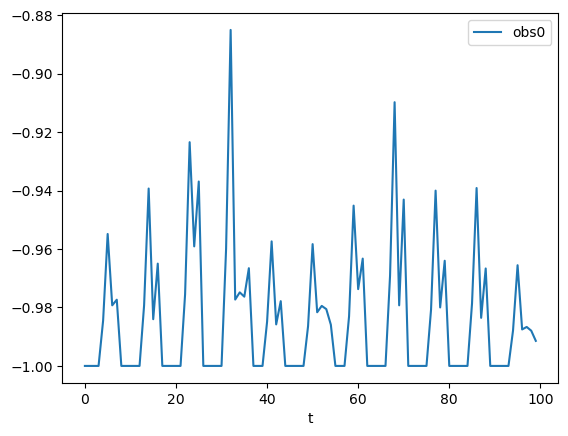

In [36]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])